In [1]:
%pylab inline
import os
import scipy
import pyiga as iga
from pyiga import geometry, assemble, vis 
import pandas as pd
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


Let $\Omega$ be quarter annulus
$$ 
    \Omega = \Big\{ 
    r \begin{pmatrix} \sin(\phi) \\ \cos(\phi) \end{pmatrix} 
    \ \Big| \ 
    1 < r < 2, 0 < \phi < \frac{\pi}{2}
    \Big\}
$$

Fix solution $u: \Omega \rightarrow \mathbb{R}$ by
$$
\begin{split}
    u(r,\phi) &= (r-1)(r-2) \sin(2\phi) \\
    \implies \Delta u(r, \phi) &= \frac{9 r - 8}{r^2} \sin(2\phi)
\end{split}
$$

Thus solve homogeneous PDE 
$$
\begin{split}
    \Delta u = \frac{9 r - 8}{r^2} \sin(2\phi) & \quad \text{ in } \Omega \\
    u = 0 & \quad \text{ on } \partial \Omega
\end{split}
$$

In [2]:
#source term
def f(x,y): 
    r = sqrt(x**2 + y**2)
    phi = arctan(y/x)
    return (9/r-8/r**2) * sin(2*phi)

g = lambda x,y: 0. #zero boundary conditions

In [3]:
def true_solution(x,y, grad=False):
    r = sqrt(x**2 + y**2)
    phi = arctan(y/x)
    u = -(r-1)*(r-2)*sin(2*phi)
    if not grad: return u
    
    dr_u = -(2*r-3)*sin(2*phi)
    dphi_u = -2*(r-1)*(r-2)*cos(2*phi)
    du = zeros((2, *u.shape)) 
    du[0,:,:] = cos(phi) * dr_u - sin(phi)/r * dphi_u
    du[1,:,:] = sin(phi) * dr_u + cos(phi)/r * dphi_u
    return u, du

/home/luca/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


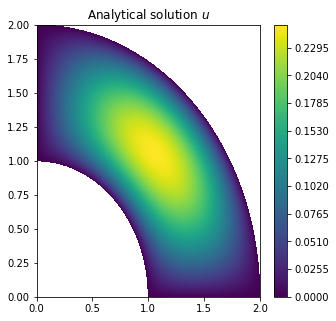

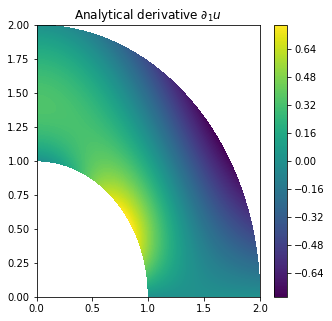

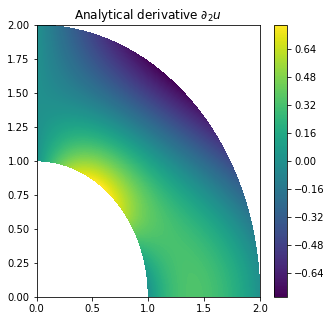

In [19]:
t = linspace(0,1,100), linspace(0,1,100)
annulus = iga.geometry.quarter_annulus()
xy = annulus.grid_eval(t)
x,y = xy[:,:,0], xy[:,:,1]
z_true, grad_z_true = true_solution(x,y, grad=True)

figsize(5,5)
levels, cmap = 200,'viridis'

title("Analytical solution $u$")
contourf(x,y,z_true, levels=200, cmap=cmap)
colorbar()
show()
title("Analytical derivative $\\partial_1 u$")
contourf(x,y,grad_z_true[0,:,:], levels=200, cmap=cmap)
colorbar()
show()
title("Analytical derivative $\\partial_2 u$")
contourf(x,y,grad_z_true[1,:,:], levels=200, cmap=cmap)
colorbar()
show()

def l2_error(u):
    z = u.grid_eval(t)
    l2e = (z - z_true)**2
    l2e = sum(l2e) / sum(z_true**2)
    l2e = sqrt( l2e )
    return l2e

def h1_error(u):
    annulus = iga.geometry.quarter_annulus()
    grad_z = u.transformed_jacobian(annulus)
    grad_z = grad_z.grid_eval(t)
    grad_z = grad_z.transpose((2,0,1))
    h1e = (grad_z - grad_z_true)**2
    h1e = sum(h1e) / sum(grad_z_true**2)
    h1e = sqrt(h1e)
    return h1e

Solver and analysis routine.

In [20]:
def solve_problem(degree=2, subdivisions=10, mult=1, analysis=False):
    annulus = iga.geometry.quarter_annulus()
    
    #refinement
    knots = iga.bspline.make_knots(degree, 0,1, subdivisions, mult)
    knots = (knots, knots)
        
    #Boundary conditions
    bcs = iga.assemble.compute_dirichlet_bcs(knots, annulus, 
            [["left", g], ["right", g], ["top", g], ["bottom", g]])

    #Assemble system
    L = iga.assemble.inner_products(knots, f, f_physical=True, geo=annulus).ravel()
    A = iga.assemble.stiffness(knots, annulus)
    system = iga.assemble.RestrictedLinearSystem(A, L, bcs)

    #Use sparse solver 
    u = scipy.sparse.linalg.spsolve(system.A, system.b)
    u_func = iga.geometry.BSplineFunc(knots, system.complete(u))
    if not analysis: return u_func
    
    #Optional: Store data for analysis
    data = dict()
    
    #h = (knots[0].meshsize_avg(), knots[1].meshsize_avg())
    h = unique(knots[0].kv), unique(knots[1].kv)
    h = max(h[0][1:]-h[0][:-1]), max(h[1][1:]-h[1][:-1])
    
    degree = (knots[0].p, knots[1].p)
    dof = iga.bspline.numdofs(knots)
    l2e = l2_error(u_func)
    h1e = h1_error(u_func)
    
    data['p'] = degree
    data['h'] = h
    data['nz'] = A.nnz
    data['dof'] = dof
    data['l2e'] = l2e
    data['h1e'] = h1e
    data['m'] = m
    return u_func, data

Example solution. 

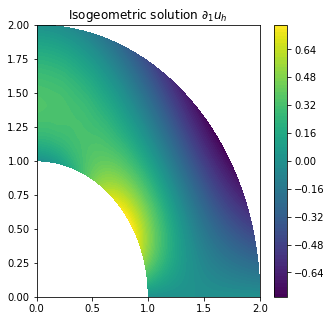

L2-error:  0.00023196937882393926
H1-error:  0.0019257293024436122


In [21]:
u = solve_problem()
annulus = iga.geometry.quarter_annulus()
grad_z = u.transformed_jacobian(annulus)
grad_z = grad_z.grid_eval(t)

figsize(5,5)
title("Isogeometric solution $u_h$")
annulus = iga.geometry.quarter_annulus()
iga.vis.plot_field(u, annulus)
colorbar()
plt.show()
title("Isogeometric solution $\\partial_1 u_h$")
contourf(x,y,grad_z[:,:,0], levels=100)
colorbar()
show()
title("Isogeometric solution $\\partial_2 u_h$")
contourf(x,y,grad_z[:,:,1], levels=100)
colorbar()
show()

print("L2-error: ", l2_error(u))
print("H1-error: ", h1_error(u))

In [22]:
measurements = pd.DataFrame()
for p in tqdm(range(1,5), desc="degree"):
    for s in [i for i in range(1,10)] +[20, 30, 40, 50, 100, 150, 200]:
        for m in [1, p]:
            
            solution, data = solve_problem(
                degree=p,
                subdivisions=s,
                mult=m, 
                analysis=True)
            data = {k:data[k] for k in data}
            data = pd.DataFrame.from_dict(data)
            measurements = measurements.append(data) 

degree: 100%|██████████| 4/4 [03:34<00:00, 53.72s/it]


In [23]:
comparisons = dict()
directory = 'data'
for f in os.listdir(directory):
    name, ext = os.path.splitext(f) 
    if ext == ".csv":
        if  "quarter" in name and \
            "annulus" in name and \
            "homogeneous" in name: 
            degree = int( name.split("_p")[-1] )

            print("Found data file '%s' for degree p=%d" % (f,degree))
            data = pd.read_csv(os.path.join(directory, f))
            comparisons[degree]  = data

Found data file 'homogeneous_quarterannulus_juafem_p2.csv' for degree p=2
Found data file 'homogeneous_quarterannulus_juafem_p1.csv' for degree p=1


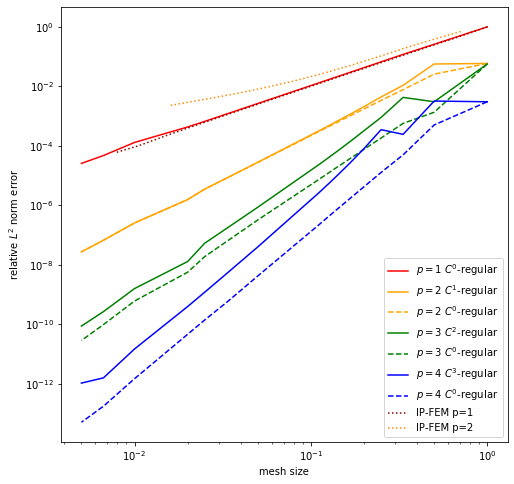

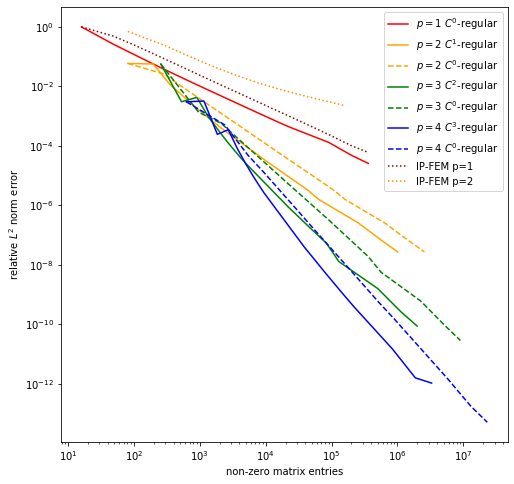

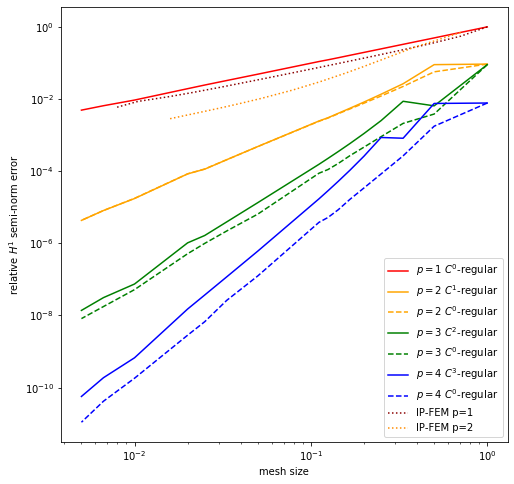

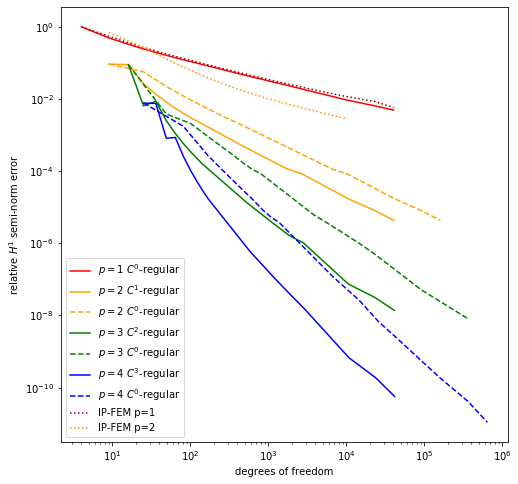

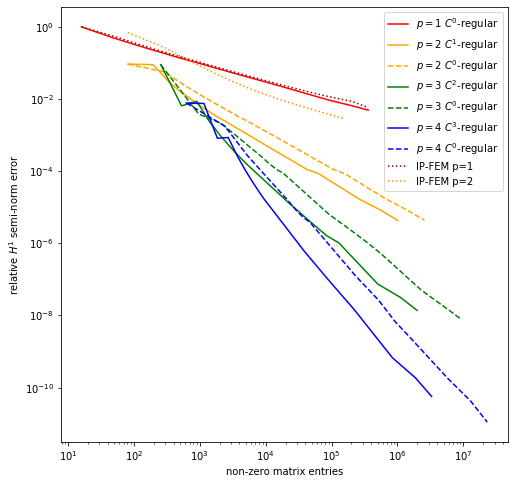

In [24]:
degrees = unique(measurements['p'])
mults = unique(measurements['m'])

figsize(8,8)
axes = { #quantities
    'h': 'mesh size',
    'dof': "degrees of freedom",
    'nz': 'non-zero matrix entries'
}
colors = { #colorize degree 
    1: 'red',
    2: 'orange',
    3: 'green',
    4: 'blue',
    5: 'purple'
}
styles = { #depict regularity with line style
    "C0" : '--',
    "Cp" : '-'
}
errors = {
    "l2e" : "relative $L^2$ norm error",
    "h1e" : "relative $H^1$ semi-norm error"
}
for e in errors:
    for q in axes:
        for p in degrees:
            for m in unique([1,p]):

                i = (measurements['p'] == p) & (measurements['m'] == m)
                err = measurements[e][i]
                v = measurements[q][i]

                label = "$p=%d$ " % p
                label += "$C^%d$" % (p-1) if m==1 else "$C^0$"
                label += "-regular"
                style = styles["Cp" if m==1 else "C0"]
                plot(v,err, label=label, c=colors[p], linestyle=style)

        for p in sorted(comparisons):
            data = comparisons[p]
            v = data[q]
            err = data[e]
            label = "IP-FEM p=%d" % p
            color = 'dark' + colors[p]
            plot(v, err, label=label, c=color, linestyle=':')

        legend()
        loglog()
        xlabel(axes[q])
        ylabel(errors[e])
        savefig('imgs/homogeneous_quarter_annulus.%s_vs_%s.png' % (q,e))
        show()